# Baseline classifier for the Mendeley Liquid Based Cytology dataset

In [1]:
RUN_ON_COLAB = False

In [2]:
if RUN_ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

The idea is to get a baseline performance benchmark on this dataset without any "advanced" data processing and modeling techniques.

1. Select a pre-trained image classification model - I chose EfficientNet V2 Small
2. Don't perform any image pre-processing or augmentation except for those except for the resizing and normalisation required by the model
3. Replace the pre-trained model's classification layer
4. Fix the top layers of the pre-trained model, i.e. only train the last few feature layers as well as the new classification layer

## Download the data

In [ ]:
!mkdir data

### Download Mendeley Liquid Based Cytology data

In [140]:
!mkdir data/mendeley

In [141]:
!cd data/mendeley && wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zddtpgzv63-2.zip
!cd data/mendeley && unzip zddtpgzv63-2.zip
!rm data/mendeley/zddtpgzv63-2.zip

--2022-08-15 18:01:54--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zddtpgzv63-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.108.120
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.108.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2212309361 (2.1G) [application/octet-stream]
Saving to: ‘zddtpgzv63-2.zip’

zddtpgzv63-2.zip    100%[===================>]   2.06G  27.3MB/s    in 79s     

2022-08-15 18:03:13 (26.7 MB/s) - ‘zddtpgzv63-2.zip’ saved [2212309361/2212309361]

Archive:  zddtpgzv63-2.zip
   creating: High squamous intra-epithelial lesion/
  inflating: High squamous intra-epithelial lesion/HSIL_8 (9).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_10 (8).jpg  
  inflating: High squamous intra-epithelial lesion/HSIL_2 (7).j

In [3]:
!mkdir data/CDetector
if RUN_ON_COLAB:
    !cp -r /content/drive/MyDrive/CDetector/dataset/* /content/data/CDetector
    !cd data/CDetector && unzip train.zip
    !rm data/CDetector/train.zip
    !cd data/CDetector && unzip test.zip
    !rm data/CDetector/test.zip
else:
    !cd data/CDetector && wget -O cdetector.tar.gz --no-check-certificate "https://onedrive.live.com/download?cid=05F351192BFCCB72&resid=5F351192BFCCB72%21329196&authkey=AAs_vqA0LsOhGpE"
    !cd data/CDetector && tar xvfz cdetector.tar.gz
    !rm data/CDetector/cdetector.tar.gz
    !cd data/CDetector && unzip train.zip
    !rm data/CDetector/train.zip
    !cd data/CDetector && unzip test.zip
    !rm data/CDetector/test.zip

--2022-08-16 06:42:47--  https://onedrive.live.com/download?cid=05F351192BFCCB72&resid=5F351192BFCCB72%21329196&authkey=AAs_vqA0LsOhGpE
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://1hanya.db.files.1drv.com/y4mFinof0tHJEkOcU-6bt65hHVbLLx1hmcVMLbQ4C-tvJonwD-VHibvq70bLQITdWbwXpRUXaPaGZDcIMxoOjnZ01NLQ7d9CRyYEFuSdCLHNs8xkEEUwODKu7rc3BOSVfWqTlTtccCwjObQ24P_M-O84rnry6e1xU9fCueaYLHJ6pgbrQ5RXawZFt6Rrcpgi3L9_y60QNP3xaQQusXS9-w9EQ/cdetector.tar.gz?download&psid=1 [following]
--2022-08-16 06:42:47--  https://1hanya.db.files.1drv.com/y4mFinof0tHJEkOcU-6bt65hHVbLLx1hmcVMLbQ4C-tvJonwD-VHibvq70bLQITdWbwXpRUXaPaGZDcIMxoOjnZ01NLQ7d9CRyYEFuSdCLHNs8xkEEUwODKu7rc3BOSVfWqTlTtccCwjObQ24P_M-O84rnry6e1xU9fCueaYLHJ6pgbrQ5RXawZFt6Rrcpgi3L9_y60QNP3xaQQusXS9-w9EQ/cdetector.tar.gz?download&psid=1
Resolving 1hanya.db.files.1drv.com (1hanya.db.files

### Download Cervix93 data

In [51]:
!cd data && git clone https://github.com/parham-ap/cytology_dataset.git
!mv data/cytology_dataset data/cervix93
!cd data/cervix93 && rm -rf codes README.md
!cd data/cervix93 && mv dataset/* .
!cd data/cervix93 && rm -rf dataset
!cd data/cervix93 && mv labels.csv labels_original.csv

Cloning into 'cytology_dataset'...
remote: Enumerating objects: 1892, done.
remote: Total 1892 (delta 0), reused 0 (delta 0), pack-reused 1892
Receiving objects: 100% (1892/1892), 756.79 MiB | 63.34 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (1794/1794), done.


## Data processing

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import random
import torch
import json

Tried to make this fairly generic so that the code can be used for other datasets. The idea is to have a data directory which contains all the image files. The images can be in subfolders, it doesn't matter.

Also in the data directory we need a csv file with two columns: relative_path and label. The relative_path is the image path from the data directory. We create this file for the Mendeley Liquid Based Cytology dataset below.

### The next two cells are to prepare the Mendeley Liquid Based Cytology data (scroll down for the CDetector data preparation steps)

In [2]:
DATA_DIR = './data/mendeley'
IMAGE_EXTENSIONS = {'jpg'}
RANDOM_SEED = 7
BASE_MODEL_SIZE = 'medium'  # 'small', 'medium'

In [150]:
subdirs = [
    fn for fn in os.listdir(DATA_DIR) 
    if os.path.isdir(os.path.join(DATA_DIR, fn))
]

# Check number of images in each subdir
files = {}
for d in subdirs:
    files[d] = [
        fn for fn in os.listdir(os.path.join(DATA_DIR, d))
        if fn.split('.')[-1] in IMAGE_EXTENSIONS
    ]

print("Number of images per class:")
total_images = 0
for k, v in files.items():
    total_images += len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total_images}")

with open(os.path.join(DATA_DIR, "labels.csv"), "w") as f:
    f.write("relative_path,label\n")
    for k, v in files.items():
        for fn in v:
            f.write(f"{os.path.join(k, fn)},{k}\n")

Number of images per class:
High squamous intra-epithelial lesion: 163
Negative for Intraepithelial malignancy: 612
Squamous cell carcinoma: 74
Low squamous intra-epithelial lesion: 113
Total: 962


### The next two cells are to prepare the CDetector data

In [34]:
DATA_DIR = './data/CDetector'
IMAGE_EXTENSIONS = {'bmp'}
RANDOM_SEED = 7
BASE_MODEL_SIZE = 'medium'  # 'small', 'medium', 'large'

In [7]:
splits = ['train', 'test']

labels = {
    'relative_path': [],
    'label': [],
    'split': []
}

for split in splits:
    
    with open(f"./data/CDetector/{split}.json", "r") as f:
        meta = json.load(f)

    annotations = {}
    for annot in meta['annotations']:
        if annot['image_id'] in annotations:
            annotations[annot['image_id']].add(str(annot['category_id']))
        else:
            annotations[annot['image_id']] = {str(annot['category_id'])}
    
    labels['relative_path'] += [os.path.join(split, image_id) for image_id in annotations.keys()]
    labels['label'] += [";".join(sorted(list(v))) for v in annotations.values()]
    labels['split'] += [split for _ in range(len(annotations))]

labels = pd.DataFrame(labels)
labels.to_csv(os.path.join(DATA_DIR, 'labels.csv'), index=None)

### The next two cells are to prepare the Cervix93 data

In [8]:
DATA_DIR = './data/cervix93'
IMAGE_EXTENSIONS = {'png'}
RANDOM_SEED = 7
BASE_MODEL_SIZE = 'small'  # 'small', 'medium', 'large'

In [9]:
MODE = "full_slide"  # 'full_slide' or 'frame'

if MODE == "full_slide":
    labels = pd.read_csv(os.path.join(DATA_DIR, "labels_original.csv"))
    labels['relative_path'] = labels['frame'].apply(lambda x: f"EDF/{x}.png")
    labels['split'] = labels['set'].apply(lambda x: 'train' if x == 0 else 'test')
    labels = labels[['relative_path', 'label', 'split']]
    labels.to_csv(os.path.join(DATA_DIR, 'labels.csv'), index=None)
else:
    subdirs = [
        fn for fn in os.listdir(DATA_DIR)
        if os.path.isdir(os.path.join(DATA_DIR, fn)) and fn != 'EDF'
    ]

    # Check number of images in each subdir
    files = {}
    for d in subdirs:
        files[d] = [
            fn for fn in os.listdir(os.path.join(DATA_DIR, d))
            if fn.split('.')[-1] in IMAGE_EXTENSIONS
        ]
    
    total_images = 0
    frames = []
    image_names = []
    for k, v in files.items():
        total_images += len(v)
        frames += [k for _ in range(len(v))]
        image_names += v
    print(f"Number of images: {total_images}")
    
    full_slide_labels = pd.read_csv(os.path.join(DATA_DIR, "labels_original.csv"))
    
    labels = pd.DataFrame(
        data={
            'image_dir': frames,
            'frame': [f.split('_')[0] for f in frames],
            'image_names': image_names
        }
    )
    labels = labels.merge(full_slide_labels, on='frame')
    
    labels['relative_path'] = labels[['image_dir', 'image_names']].apply(
        lambda x: f"{x[0]}/{x[1]}",
        axis=1
    )
    labels['split'] = labels['set'].apply(lambda x: 'train' if x == 0 else 'test')
    labels = labels[['relative_path', 'label', 'split']]
    labels.to_csv(os.path.join(DATA_DIR, 'labels.csv'), index=None)

### Load the new labels files and looks at a random image

In [35]:
labels = pd.read_csv(os.path.join(DATA_DIR, "labels.csv"))

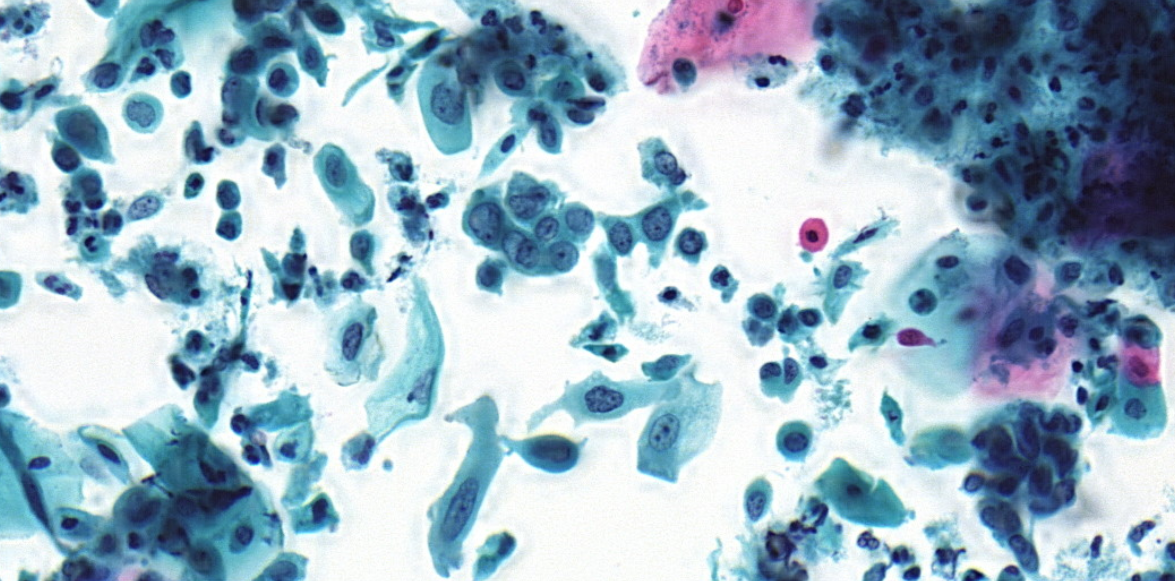

In [36]:
# Open a random image
idx = random.randint(0, len(labels)-1)
img = Image.open(os.path.join(DATA_DIR, labels['relative_path'][idx]))
# np.array(img).shape
img

## Data class

In [53]:
import os
import typing

import numpy as np
import pandas as pd
from PIL import Image

import torch


class CervData:
    def __init__(
        self, 
        data_dir: str,
        df: pd.DataFrame,
        label2ind: typing.Dict[str, int] = None,
        preprocessor: callable = None,
        shuffle: bool = False,
        random_seed: int = None,
        device: str = 'cuda',
        multi_label: bool = False,
        multi_label_sep: str = ';',
        convert_to_grayscale: bool = False
    ) -> None:
        """
        A Custom Dataset Object that holds the Images to be used for Analysis and Modelling.

        Parameters:
        -----------
        data_dir: str
            The path to the directory containing the images.
        df: pandas.DataFrame
            The dataframe containing the image paths and labels.
        preprocessor: callable
            A function that preprocesses the images.
            Function must take in a PIL.Image object and return a torch.Tensor.
        label2ind: dict (optional)
            A dictionary mapping the labels to their corresponding number.
            Is responsible for Label Encoding the labels.
            If not provided then the dictionary is created
        shuffle: bool (default: False)
            Whether to shuffle the dataset.
        random_seed: int (default: None)
            The random seed to use for shuffling.
        device: str (default: 'cuda')
            The device where the data will be stored.
        multi_label: bool (default: False)
            Whether the labels are multi-label
        multi_label_sep: str (default: ';')
            How labels are separated in the multi-label setting.
            Ignored if multi_label = False
        convert_to_grayscale: bool (default: False)
            Whether to convert images to grayscale
        """
        # Resources
        self.df = df
        self.data_dir = data_dir
        self.num_examples = len(self.df)
        self.preprocessor = preprocessor
        self.device = device
        self.random_seed = random_seed
        self.shuffle = shuffle
        self.convert_to_grayscale = convert_to_grayscale

        # Process Resources
        if shuffle:
            self._shuffle(random_seed=random_seed)
        
        # Label Metadata Map
        self.multi_label = multi_label
        self.multi_label_sep = multi_label_sep
        if label2ind is not None:
            self.label2ind = label2ind
        else:
            self.label2ind = self._enumerate_labels()
        self.ind2label = {v: k for k, v in self.label2ind.items()}

        # Misc
        self.num_labels = len(self.label2ind)
    
    def __str__(self):
        return f'''
        CervData Object
        --------
        
        Properties:
        -----------
        data_dir:             {self.data_dir}
        preprocessor:         {'Set' if self.preprocessor is not None else 'Not Set'}
        shuffle:              {self.shuffle}
        random_seed:          {self.random_seed}
        convert_to_grayscale  {self.convert_to_grayscale}

        Internal Properties:
        ---------------------
        num_labels:           {self.num_labels}
        num_examples:         {self.num_examples}
        multi_label:          {self.multi_label}
        '''
        
    def get_batch(
        self,
        s_idx: int,
        e_idx: int, 
        return_labels: bool = True
    ) -> typing.Dict[str, torch.Tensor]:
        """
        Returns a batch of images (and labels) depending on the index.
        Is a wrapper for the _get_batch_images and _get_batch_labels methods.

        Parameters:
        -----------
        s_idx: int
            The start index of the batch in the dataset
        e_idx: int
            The end index of the batch in the dataset
        return_labels: bool (default: True)
            A flag to indicate whether to return the labels or not

        Returns:
        --------
        input_dict: dict
            A dictionary containing 'x' and 'y' as keys.
            x: torch.Tensor
                The Image Tensor from s_idx to e_idx
            y: torch.Tensor
                The Label Tensor from s_idx to e_idx
        """
        input_dict = self._get_batch_images(s_idx, e_idx)
        if return_labels:
            input_dict['targets'] = self._get_batch_labels(s_idx, e_idx)
        return input_dict

    def sample(self, amount: int) -> typing.Dict[str, typing.List]:
        """
        Returns a random sample of the dataset of size amount.

        Parameters:
        -----------
        amount: int
            The amount of images to return

        Returns:
        --------
        sample: dict
            A dictionary containing the images and labels.
        """
        batch_image_idx = [np.random.randin(0, self.num_examples) for _ in range(amount)]
        batch_images = [
            Image.open(os.path.join(self.data_dir, fn)) 
            for fn in self.df.iloc[batch_image_idx, 'relative_path']
        ]
        batch_labels = self.df.iloc[batch_image_idx, 'label'].values.tolist()
        return {
            'images': batch_images,
            'labels': batch_labels
        }

    def _get_batch_images(self, s_idx: int, e_idx: int) -> typing.Dict[str, torch.Tensor]:
        if self.preprocessor is None:
            raise Exception("No Preprocessor Specified! Please Specify a Preprocessor.")
        '''
        Returns a batch of images depending on the index.

        Parameters:
        -----------
        s_idx: int
            The start index of the batch in the dataset.
        e_idx: int
            The end index of the batch in the dataset.

        Returns:
        --------
        images: Dict[str, torch.Tensor]
            A dictionary containing the preprocessed image tensors as a unified tensor 
            placed on the device.
        '''
        batch_image_paths = [
            os.path.join(self.data_dir, fn) for fn in self.df['relative_path'][s_idx:e_idx]
        ]
        batch_images = []
        for fn in batch_image_paths:
            image = Image.open(fn)
            if self.convert_to_grayscale:
                image = image.convert('L')
            image_arr = np.array(image)
            # Expand dimensions for grayscale images
            if len(image_arr.shape) == 2:
                image_arr = np.repeat(image_arr[..., np.newaxis], 3, -1)
                image = Image.fromarray(image_arr)
            batch_images.append(image)
        batch_images = [self.preprocessor(img).unsqueeze(0) for img in batch_images]
        batch_images = torch.cat(batch_images)
        batch_images = batch_images.to(self.device)
        return {'x': batch_images}
    
    def _get_batch_labels(self, s_idx: int, e_idx: int) -> torch.Tensor:
        """
        Returns a batch of labels depending on the index.

        Parameters:
        -----------
        s_idx: int
            The start index of the batch in the dataset.
        e_idx: int
            The end index of the batch in the dataset.

        Returns:
        --------
        labels: torch.Tensor
            A tensor containing the labels of the batch.
        """
        batch_labels = self.df['label'][s_idx:e_idx]
        batch_labels_arr = torch.zeros(
            (len(batch_labels), self.num_labels),
            device=self.device
        )
        for i, label in enumerate(batch_labels):
            if self.multi_label:
                for label_ in label.split(self.multi_label_sep):
                    batch_labels_arr[i, self.label2ind[label_]] = 1
            else:
                batch_labels_arr[i, self.label2ind[label]] = 1
        return batch_labels_arr

    def _shuffle(self, random_seed: int = None) -> None:
        """Shuffles the dataset."""
        self.df = self.df.sample(frac=1, replace=False, random_state=random_seed).copy()

    def _enumerate_labels(self):
        if self.multi_label:
            labels = set()
            for label_str in self.df['label'].drop_duplicates():
                for label in label_str.split(self.multi_label_sep):
                    labels.add(label)
            labels = sorted(list(labels))
        else:
            labels = self.df['label'].drop_duplicates()
        label2ind = {
            label: i for i, label in enumerate(labels)
        }
        return label2ind

    def set_preprocessor(self, preprocessor: callable) -> None:
        """Sets the preprocessor for the dataset."""
        self.preprocessor = preprocessor


In [23]:
class CervData:
    def __init__(
        self, data_dir, df, preprocessor, label2ind=None, shuffle=False,
        random_seed=None, device='cuda', multi_label=False, multi_label_sep=';',
        convert_to_grayscale=False
    ):
        self.df = df
        self.data_dir = data_dir
        self.num_examples = len(self.df)
        
        self.multi_label = multi_label
        self.multi_label_sep = multi_label_sep
        
        if shuffle:
            self.shuffle(random_seed=random_seed)
        
        if label2ind is not None:
            self.label2ind = label2ind
        else:
            self.label2ind = self.enumerate_labels()
        self.ind2label = {v: k for k, v in self.label2ind.items()}
            
        self.num_labels = len(self.label2ind)
        self.preprocessor = preprocessor
        
        self.device = device
        
        self.convert_to_grayscale = convert_to_grayscale

    def get_batch(self, s_idx, e_idx, return_labels=True):
        input_dict = self.get_batch_images(s_idx, e_idx)
        if return_labels:
            input_dict['targets'] = self.get_batch_labels(s_idx, e_idx)
        return input_dict
        
    def get_batch_images(self, s_idx, e_idx):
        batch_image_paths = [
            os.path.join(self.data_dir, fn) for fn in self.df['relative_path'][s_idx:e_idx]
        ]
        batch_images = []
        for fn in batch_image_paths:
            image = Image.open(fn)
            if self.convert_to_grayscale:
                image = image.convert('L')
            image_arr = np.array(image)
            # Expand dimensions for grayscale images
            if len(image_arr.shape) == 2:
                image_arr = np.repeat(image_arr[..., np.newaxis], 3, -1)
                image = Image.fromarray(image_arr)
            batch_images.append(image)
        batch_images = [self.preprocessor(img).unsqueeze(0) for img in batch_images]
        batch_images = torch.cat(batch_images)
        batch_images = batch_images.to(self.device)
        return {'x': batch_images}
    
    def get_batch_labels(self, s_idx, e_idx):
        batch_labels = self.df['label'][s_idx:e_idx]
        batch_labels_arr = torch.zeros(
            (len(batch_labels), self.num_labels),
            device=self.device
        )
        for i, label in enumerate(batch_labels):
            if self.multi_label:
                for label_ in label.split(self.multi_label_sep):
                    batch_labels_arr[i, self.label2ind[label_]] = 1
            else:
                batch_labels_arr[i, self.label2ind[label]] = 1
        return batch_labels_arr
    
    def enumerate_labels(self):
        if self.multi_label:
            labels = set()
            for label_str in self.df['label'].drop_duplicates():
                for label in label_str.split(self.multi_label_sep):
                    labels.add(label)
            labels = sorted(list(labels))
        else:
            labels = self.df['label'].drop_duplicates()
        label2ind = {
            label: i for i, label in enumerate(labels)
        }
        return label2ind
            
    def shuffle(self, random_seed=None):
        self.df = self.df.sample(frac=1, replace=False, random_state=random_seed).copy()

## Base model

In [7]:
if BASE_MODEL_SIZE == 'small':
    from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

    weights = EfficientNet_V2_S_Weights.DEFAULT
    base_model = efficientnet_v2_s(weights=weights)
    base_model = base_model.to("cuda")
elif BASE_MODEL_SIZE == 'medium':
    from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

    weights = EfficientNet_V2_M_Weights.DEFAULT
    base_model = efficientnet_v2_m(weights=weights)
    base_model = base_model.to("cuda")
elif BASE_MODEL_SIZE == 'large':
    from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights

    weights = EfficientNet_V2_L_Weights.DEFAULT
    base_model = efficientnet_v2_l(weights=weights)
    base_model = base_model.to("cuda")
else:
    raise NotImplementedError("BASE_MODEL_SIZE must be 'small', 'medium' or 'large'")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

In [8]:
preprocess = weights.transforms()

## Prepare the data to train the ML model

In [37]:
DATASET = 'CDetector'  # Mendeley, CDetector or Cervix93

We shuffle the file labels file and then create train, validation and test splits.

In [38]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(os.path.join(DATA_DIR, "labels.csv"))

if DATASET in ('Mendeley', 'Cervix93'):
    
    label2ind = {
        label: i for i, label in enumerate(df['label'].drop_duplicates())
    }
    df = df.sample(
        frac=1, replace=False, random_state=RANDOM_SEED
    ).copy()
    
    if DATASET == 'Mendeley':
        num_classes = 4
        df_train, df_test = train_test_split(df, train_size=0.8, random_state=RANDOM_SEED)
    else:
        num_classes = 3
        df_train = df[df['split'] == 'train'].copy()
        df_test = df[df['split'] == 'test'].copy()
    df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=RANDOM_SEED)

elif DATASET == 'CDetector':
    num_classes = 11

    label2ind = {str(i + 1): i for i in range(11)}

    df_train = df[df['split'] == 'train'].copy()
    df_test = df[df['split'] == 'test'].copy()
    df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=RANDOM_SEED)

else:
    raise NotImplementedError("Error: DATASET must be Mendeley or CDetector")

print(f"Train size:      {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size:       {len(df_test)}")

Train size:      5332
Validation size: 1334
Test size:       744


**See below the usage of the data generator class:**

In [54]:
convert_to_grayscale = True

train_data = CervData(
    data_dir=DATA_DIR,
    df=df_train,
    label2ind=None,
    shuffle=True,
    random_seed=RANDOM_SEED,
    preprocessor=preprocess,
    multi_label=True if DATASET == 'CDetector' else False,
    multi_label_sep=';',
    convert_to_grayscale=convert_to_grayscale,
    device='cuda'
)

val_data = CervData(
    data_dir=DATA_DIR,
    df=df_val,
    label2ind=train_data.label2ind,
    shuffle=True,
    random_seed=RANDOM_SEED,
    preprocessor=preprocess,
    multi_label=True if DATASET == 'CDetector' else False,
    multi_label_sep=';',
    convert_to_grayscale=convert_to_grayscale,
    device='cuda'
)

test_data = CervData(
    data_dir=DATA_DIR,
    df=df_test,
    label2ind=train_data.label2ind,
    shuffle=True,
    random_seed=RANDOM_SEED,
    preprocessor=preprocess,
    multi_label=True if DATASET == 'CDetector' else False,
    multi_label_sep=';',
    convert_to_grayscale=convert_to_grayscale,
    device='cuda'
)

**Let's look at the label distribution:**

In [55]:
for data in (train_data, val_data, test_data):
    tmp = data._get_batch_labels(0, data.num_examples)
    counts = tmp.sum(axis=0).cpu().numpy()
    tmp = pd.DataFrame(
        data={
            'Label': label2ind.keys(),
            'count': counts,
        }
    )
    tmp['proportion'] = tmp['count'] / data.num_examples
    print(tmp.set_index('Label'))

        count  proportion
Label                    
1       733.0    0.137472
2       141.0    0.026444
3        45.0    0.008440
4      1156.0    0.216804
5       721.0    0.135221
6      2701.0    0.506564
7       256.0    0.048012
8       758.0    0.142161
9       418.0    0.078395
10      182.0    0.034134
11       29.0    0.005439
       count  proportion
Label                   
1      169.0    0.126687
2       37.0    0.027736
3        7.0    0.005247
4      271.0    0.203148
5      156.0    0.116942
6      672.0    0.503748
7       63.0    0.047226
8      214.0    0.160420
9      130.0    0.097451
10      35.0    0.026237
11       9.0    0.006747
       count  proportion
Label                   
1       98.0    0.131720
2       22.0    0.029570
3        6.0    0.008065
4      150.0    0.201613
5      109.0    0.146505
6      357.0    0.479839
7       28.0    0.037634
8      122.0    0.163978
9       62.0    0.083333
10      20.0    0.026882
11       7.0    0.009409


# Construct our classifier

In [56]:
from torch import nn


class CervEffNet(nn.Module):
    def __init__(self, base_model, num_classes, freeze_top_n=0, multi_label=False):
        super(CervEffNet, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(
                in_features=1280,
                out_features=num_classes,
                bias=True
            )
        )
        
        torch.nn.init.xavier_uniform_(self.classifier[1].weight)
        torch.nn.init.constant_(self.classifier[1].bias, 0)
        
        if freeze_top_n > 0:
            self.freeze_top(freeze_top_n)
        
        if multi_label:
            self.prob_func = nn.Sigmoid()
            self.loss_func = nn.BCEWithLogitsLoss()
        else:
            self.prob_func = nn.Softmax(dim=1)
            self.loss_func = nn.CrossEntropyLoss()
        
    def freeze_top(self, top_n=1):
        for param in self.features[:top_n].parameters():
            param.requires_grad = False
    
    def forward(self, x, targets=None):
        features = self.avgpool(
            self.features(x)
        )
        out = self.classifier(features.squeeze())
        
        outputs = {
            'pooled_output': out,
            'probabilities': self.prob_func(out)
        }
        
        if targets is not None:
            outputs['loss'] = self.loss_func(out, targets)
            
        return outputs

The EfficientNet base model has a total of 8 layers before the classification layers. We freeze the first six, i.e. we make only the last two feature layers trainable.

In [57]:
model = CervEffNet(
    base_model,
    num_classes=num_classes,
    freeze_top_n=6,
    multi_label=True if DATASET == 'CDetector' else False
)
model = model.to("cuda")

In [58]:
# LOAD_WEIGHTS_PATH = './saved_models/model_cdetector.pt'
# LOAD_WEIGHTS_PATH = './saved_models/model_mendeley.pt'
# LOAD_WEIGHTS_PATH = './saved_models/model_mendeley_gs.pt'
LOAD_WEIGHTS_PATH = None

if LOAD_WEIGHTS_PATH is not None:
    weights = torch.load(LOAD_WEIGHTS_PATH)

    from collections import OrderedDict

    base_weights = OrderedDict()

    for k, v in weights.items():
        if k.split('.')[0] != 'classifier':
            base_weights[k] = v
    
    out = model.load_state_dict(base_weights, strict=False)
    print(out)
    
    model.freeze_top(top_n=6)

# Train the model

In [59]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm.notebook import tqdm

def pytorch_training_loop(
    model, optimizer, train_data, val_data, num_labels,
    start_epoch, total_epochs, batch_size, model_save_path,
    scheduler=None, best_val_score=0, patience=5, shuffle_data=False
):

    epoch = start_epoch
    n_train = train_data.num_examples
   
    non_improvement = 0
    
    for epoch in range(epoch, total_epochs):
            
        epoch_loss = 0
        epoch_p = 0
        epoch_r = 0
        epoch_f = 0
        epoch_test_steps = 0

        print("Training epoch {}".format(epoch+1))
        if non_improvement > 0:
            print("Early stopping {}/{}".format(non_improvement, patience))

        model.train()
        
        if shuffle_data:
            train_data.shuffle(random_seed=epoch)

        pbar = tqdm(range(0, n_train, batch_size), unit="steps", desc="Training")

        # Training loop
        for i in pbar:
            end_ix = min(i+batch_size, n_train)
            start_ix = end_ix - batch_size
            step_count = int(start_ix/batch_size)

            input_dict = train_data.get_batch(start_ix, end_ix, return_labels=True)
            
            optimizer.zero_grad()
            
            model_output = model(**input_dict)
            loss = model_output['loss']
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            
            if step_count % 10 == 0:
                probabilities = model_output[
                    'probabilities'].detach().cpu().numpy()
                predictions = (probabilities > 0.5).astype(np.int32)
                p, r, f, _ = precision_recall_fscore_support(
                    input_dict['targets'].cpu().detach().numpy(),
                    predictions,
                    average='weighted',
                    zero_division=0
                )
                epoch_test_steps += 1
                epoch_loss += loss.detach().item()
                epoch_p += p
                epoch_r += r
                epoch_f += f
                pbar.set_postfix_str(
                    "Loss {:.4f}, Precision {:.4f}, Recall {:.4f}, F1 {:.4f}".format(
                        epoch_loss/epoch_test_steps,
                        epoch_p/epoch_test_steps,
                        epoch_r/epoch_test_steps,
                        epoch_f/epoch_test_steps
                    )
                )

        # Validation loop
        val_probs, val_targs = pytorch_testing_loop(
            model, val_data, num_labels, batch_size
        )
        val_predictions = (val_probs > 0.5).astype(np.int32)
        val_p, val_r, val_f, _ = precision_recall_fscore_support(
            val_targs,
            val_predictions,
            average='weighted',
            zero_division=0
        )
        if val_f >= best_val_score:
            best_val_score = val_f
            non_improvement = 0
            torch.save(model.state_dict(), model_save_path)
        else:
            non_improvement += 1
        print('Precision (val): {:.4f}, Recall (val): {:.4f}, F1 (val): {:.4f} | Best validation F1: {:.4f}\n'.format(
            val_p, val_r, val_f, best_val_score)
        )
        
        if non_improvement == patience:
            return best_val_score
        
        if scheduler is not None:
            scheduler.step(val_f)
        
    return best_val_score


def pytorch_testing_loop(model, test_data, num_labels, batch_size):

    n_test = test_data.num_examples
    
    # Testing loop
    test_probs = np.zeros((n_test, num_labels))
    test_targs = np.zeros((n_test, num_labels))
    model.eval()

    pbar = tqdm(range(0, n_test, batch_size), unit="steps", desc="Testing")
    for i in pbar:
        end_ix = min(i+batch_size, n_test)
        start_ix = end_ix - batch_size

        input_dict = test_data.get_batch(start_ix, end_ix, return_labels=True)
        
        with torch.no_grad():
            model_output = model(**input_dict)
        
        _probs = model_output['probabilities'].detach().cpu().numpy()
        test_probs[start_ix:end_ix, :] = _probs
        test_targs[start_ix:end_ix, :] = input_dict['targets'].detach().cpu().numpy()

    return test_probs, test_targs

In [60]:
alt_optimizer = False

if alt_optimizer:
    optimizer = torch.optim.Adam(
        [
            {'params': model.features.parameters(), 'lr': 2e-05},
            {'params': model.classifier.parameters()},
        ],
        lr=3e-04
    )
    model.freeze_top(top_n=6)
else:
    optimizer = torch.optim.Adam(
    model.parameters(),
    weight_decay=0,
    lr=3e-04
)

In [61]:
scheduler = None
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1, factor=0.1)

In [62]:
if not os.path.exists('saved_models'):
    os.mkdir('./saved_models')

In [63]:
val_score = pytorch_training_loop(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    val_data=val_data,
    num_labels=train_data.num_labels,
    start_epoch=0,
    total_epochs=30,
    batch_size=8,
    model_save_path='saved_models/model.pt',
    scheduler=scheduler,
    best_val_score=0,
    patience=5,
    shuffle_data=False,
)

Training epoch 1


Training:   0%|          | 0/667 [00:00<?, ?steps/s]

KeyboardInterrupt: 

In [63]:
model.load_state_dict(torch.load('saved_models/model.pt'))

average = 'macro'

test_probs, test_targs = pytorch_testing_loop(
    model=model,
    test_data=test_data,
    num_labels=test_data.num_labels,
    batch_size=8
)
test_predictions = (test_probs > 0.5).astype(np.int32)

test_p, test_r, test_f, _ = precision_recall_fscore_support(
    test_targs,
    test_predictions,
    average=average,
    zero_division=0
)
print(f"Precision ({average}) (test) {test_p:.4f}")
print(f"Recall ({average}) (test)    {test_r:.4f}")
print(f"F1 ({average}) (test)        {test_f:.4f}")

if DATASET in ('Mendeley', 'Cervix93'):
    pred_index = np.argmax(test_predictions, axis=1)
    target_index = np.argmax(test_targs, axis=1)
    correct = [p == y for p, y in zip(pred_index, target_index)]
    print(f"Test accuracy:           {np.mean(correct)*100:.2f}%")

Testing:   0%|          | 0/93 [00:00<?, ?steps/s]

Precision (macro) (test) 0.8123
Recall (macro) (test)    0.7529
F1 (macro) (test)        0.7656


In [64]:
if DATASET in ('Mendeley', 'Cervix93'):
    print("Confusion matrix")
    print(label2ind)
    print(confusion_matrix(np.argmax(test_targs, axis=1), np.argmax(test_predictions, axis=1)))

In [65]:
print("F1 per label")
ind2label = {v: k for k, v in label2ind.items()}
for i in range(test_targs.shape[1]):
    p, r, f, _ = precision_recall_fscore_support(
        test_targs[:, i],
        test_predictions[:, i],
        average='binary',
        zero_division=0
    )
    print(ind2label[i], f)

F1 per label
1 0.6666666666666666
2 0.592797783933518
3 0.6755555555555556
4 0.9217877094972067
5 0.5116279069767441
6 0.8765957446808511
7 0.9279999999999999
8 0.9268292682926829
9 0.6
10 0.888888888888889
11 0.8333333333333334


In [44]:
!cp saved_models/model.pt saved_models/model_cdetector.pt

In [23]:
!cp saved_models/model.pt saved_models/model_mendeley.pt

In [119]:
!cp saved_models/model.pt saved_models/model_cervix.pt

In [23]:
!cp saved_models/model.pt saved_models/model_mendeley_gs.pt

In [66]:
!cp saved_models/model.pt saved_models/model_cdetector_gs.pt

### Some extra WIP

In [99]:
import torchvision

# transforms = torch.nn.Sequential(
preprocess = torchvision.transforms.Compose([
    preprocess,
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomVerticalFlip(0.5),
    torchvision.transforms.RandomRotation(0.5)
])
# scripted_transforms = torch.jit.script(transforms)
# scripted_transforms
preprocess

NameError: name 'transforms' is not defined

In [148]:
ind2label = {v: k for k, v in label2ind.items()}
test_labels = np.argmax(test_predictions, axis=1)
test_labels = [ind2label[x] for x in test_labels]
df = test_data.df.copy()
df['predicted'] = test_labels
rank = {'N': 0, 'L': 1, 'H': 2}
rank_inv = {v: k for k, v in rank.items()}
df['label_rank'] = df['label'].apply(lambda x: rank[x])
df['predicted_rank'] = df['predicted'].apply(lambda x: rank[x])
df['frame'] = df['relative_path'].apply(lambda x: x.split('/')[0].split('_')[0])
df = df.groupby('frame').max()[['label_rank', 'predicted_rank']]
df['label'] = df['label_rank'].apply(lambda x: rank_inv[x])
df['predicted'] = df['predicted_rank'].apply(lambda x: rank_inv[x])
df['count'] = 1

In [149]:
pd.pivot_table(
    data=df,
    index='label',
    columns='predicted',
    values='count',
    aggfunc='count'
)

predicted,H,L,N
label,,,
H,5.0,3.0,NaN
L,6.0,6.0,NaN
N,NaN,3.0,1.0


In [137]:
ind2label

{0: 'L', 1: 'H', 2: 'N'}